In [2]:
#TEAM ID : PNT2022TMID03970

import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os import getcwd
from os import listdir
import cv2
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
import imutils
import numpy as np
import matplotlib.pyplot as plt

In [4]:
TRAINING_DIR = (r"C:\Users\HP\Dataset Plant Disease\fruit-dataset\fruit-dataset\train")

train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

Found 5384 images belonging to 6 classes.


In [5]:
VALIDATION_DIR = (r"C:\Users\HP\Dataset Plant Disease\fruit-dataset\fruit-dataset\test")

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

Found 1686 images belonging to 6 classes.


In [6]:
%load_ext tensorboard

In [7]:
from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.5.0


In [8]:
import tensorboard
tensorboard.__version__

'2.5.0'

In [9]:
#model building using MobileNetV2

from tensorflow.keras.applications import MobileNetV2
basemodel=MobileNetV2(weights="imagenet",include_top=False,
                      input_tensor=Input(shape=(224,224,3)))
model=basemodel.output
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(100, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(100, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')
    
])
#model summary
print(basemodel.summary())

`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [10]:
(train_images, train_labels), _ = keras.datasets.fashion_mnist.load_data()
train_images = train_images / 255.0

In [11]:
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Train the model.
opt=tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])


history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=3,
            verbose=1)

Epoch 1/3
54/54 [==============================] - 309s 6s/step - loss: 1.3279 - acc: 0.5433 - val_loss: 0.6847 - val_acc: 0.7509
Epoch 2/3
54/54 [==============================] - 260s 5s/step - loss: 0.6325 - acc: 0.7608 - val_loss: 0.4549 - val_acc: 0.8505
Epoch 3/3
54/54 [==============================] - 261s 5s/step - loss: 0.4720 - acc: 0.8267 - val_loss: 0.4060 - val_acc: 0.8535


In [12]:
model.evaluate(validation_generator)

17/17 [==============================] - 18s 1s/step - loss: 0.4060 - acc: 0.8535


[0.4059935510158539, 0.8534994125366211]

In [13]:
model.save('Fruit_MobileNetV2.h5')

In [14]:
from keras.preprocessing.image import load_img,img_to_array

dic=train_generator.class_indices

icd={k:v for v,k in dic.items()}

def output(location):

    img=load_img(location,target_size=(150,150,3))

    img=img_to_array(img)

    img=img/255

    img=np.expand_dims(img,[0])

    answer=model.predict_classes(img)

    probability=round(np.max(model.predict_proba(img)*100),2)
    print ("**",icd[answer[0]], 'With probability',probability,"\n")

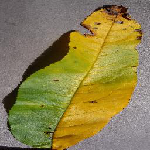

In [15]:
img=r"C:\Users\HP\Dataset Plant Disease\fruit-dataset\fruit-dataset\test\Peach___Bacterial_spot\0acacb6e-3517-4277-ab89-2cd9636d8b45___Rutg._Bact.S 1442.JPG"
s=load_img(img,target_size=(150,150,3))
s

In [16]:
output(img)

C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


** Peach___Bacterial_spot With probability 100.0 



C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


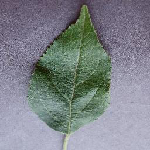

In [17]:
img=r"C:\Users\HP\Dataset Plant Disease\fruit-dataset\fruit-dataset\test\Apple___healthy\0adc1c5b-8958-47c0-a152-f28078c214f1___RS_HL 7825.JPG"
s=load_img(img,target_size=(150,150,3))
s

In [18]:
output(img)

** Apple___healthy With probability 80.21 



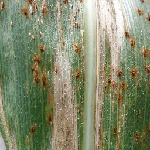

In [19]:
img=r"C:\Users\HP\Dataset Plant Disease\fruit-dataset\fruit-dataset\test\Corn_(maize)___Northern_Leaf_Blight\5df7a420-aeab-4eb0-959a-290e4bb2a944___RS_NLB 3514 copy 2.jpg"
s=load_img(img,target_size=(150,150,3))
s

In [20]:
output(img)

** Corn_(maize)___Northern_Leaf_Blight With probability 98.21 



Text(0.5, 1.0, 'Training and validation loss')

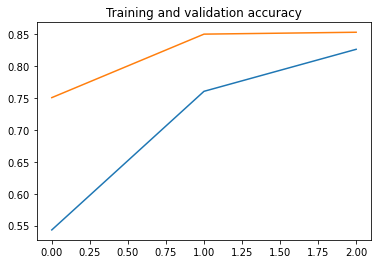

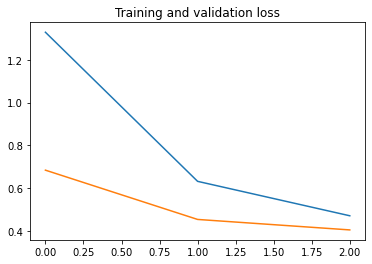

In [21]:
acc      = history.history['acc' ]
val_acc  = history.history[ 'val_acc' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) 

plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )